In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/Users/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [323]:
dtype = torch.float64

In [324]:
import importlib
importlib.reload(utils)
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(sampling)
importlib.reload(training)
importlib.reload(callback)

<module 'callback' from '/Users/scrotti/Aptamer2025py/callback.py'>

## Generate

In [325]:
tr = tree.Tree()
tr.add_node(-1, name = "round 1 with selection")
tr.add_node(0, name = "round 2 with selection")
tr.add_node(-1, name = "round 1 without selection")

selected_modes = torch.BoolTensor(
    [[1, 1, 0],
     [1, 1, 0],
     [0, 1, 0]]
)

n_selection_rounds, n_modes = selected_modes.size()
assert n_selection_rounds == tr.get_n_nodes()
n_rounds = n_selection_rounds + 1

In [326]:
L, q = 45, 4

k_teacher = torch.randn(L, q, dtype=dtype)
h_teacher = torch.randn(L, q, dtype=dtype)
h_beads_teacher = 1e-2 * torch.randn(L, q, dtype=dtype)
J_ = torch.randn(L*q, L*q, dtype=dtype) / torch.sqrt(torch.Tensor([L]).to(dtype=dtype))
J_ = J_ + J_.t()
J_teacher = J_.reshape(L, q, L, q)

Ns0 = energy_models.IndepSites(k_teacher)
potts = energy_models.Potts(J_teacher, h_teacher)
beads = energy_models.IndepSites(h_beads_teacher)
unbound_mode = energy_models.ConstantEnergy(-10)

ps = selex_distribution.MultiModeDistribution(potts, beads, unbound_mode, normalized=True)
model_teacher = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)
model_teacher.train(mode=False);

In [327]:
n_chains = 10**5
chains_teacher = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)

In [328]:
n_sweeps = 20
energies = model_teacher.sample(chains_teacher, n_sweeps)

In [329]:
sequences_oh = chains_teacher
total_reads = total_reads = torch.Tensor([sequences_oh.shape[1] for _ in range(n_rounds)])

## Learn

In [375]:
L, q = 45, 4

k = torch.randn(L, q, dtype=dtype)
h = torch.randn(L, q, dtype=dtype)
h_beads = 1e-2 * torch.randn(L, q, dtype=dtype)
J_ = torch.randn(L*q, L*q, dtype=dtype) / torch.sqrt(torch.Tensor([L]).to(dtype=dtype))
J_ = J_ + J_.t()
J = J_.reshape(L, q, L, q)
potts = energy_models.Potts(J, h)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
beads = energy_models.IndepSites(h_beads)
unbound_mode = energy_models.ConstantEnergy(-10)

ps = selex_distribution.MultiModeDistribution(potts, beads, unbound_mode, normalized=True)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [376]:
batch_size = 10**4
data_loaders = [data_loading.SelexRoundDataLoader(sequences_oh[id], batch_size=batch_size, device=torch.device('cpu')) 
                for id in range(n_rounds)]

In [377]:
n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [378]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.TeacherStudentCallback(model_teacher)]

In [379]:
lr = 0.01
optimizer = torch.optim.Adam([
                            {'params': model.selection.parameters(), 'lr': 0.5},
                            {'params': model.round_zero.parameters(), 'lr': lr}
                        ])

In [ ]:
n_sweeps = 10
target_pearson = 1
max_epochs = 2000

training.train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, target_pearson, 
               callbacks=callbacks, log_weights=log_weights,
               optimizer = optimizer)

 0.00%[                             ] Epoch: 0/2000 [00:00, ?it/s]

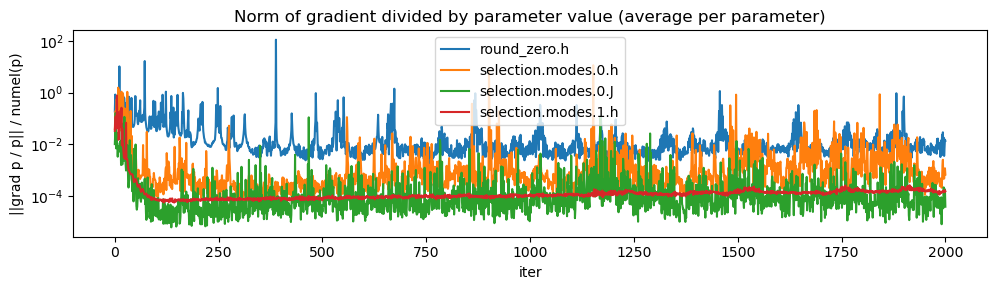

In [389]:
callbacks[0].plot_gradient_parameter_ratio();

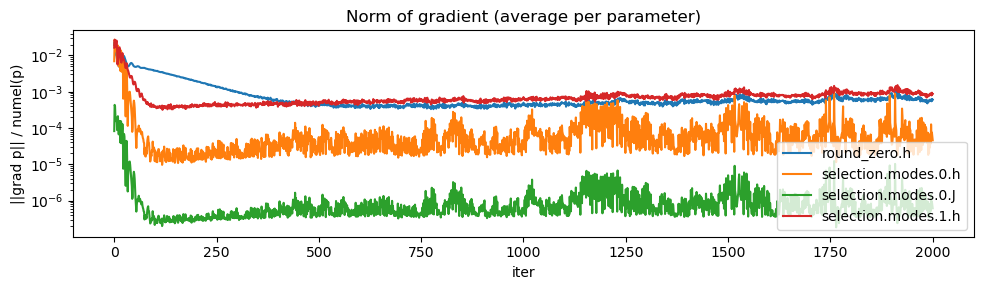

In [390]:
callbacks[0].plot_parameter_norm();

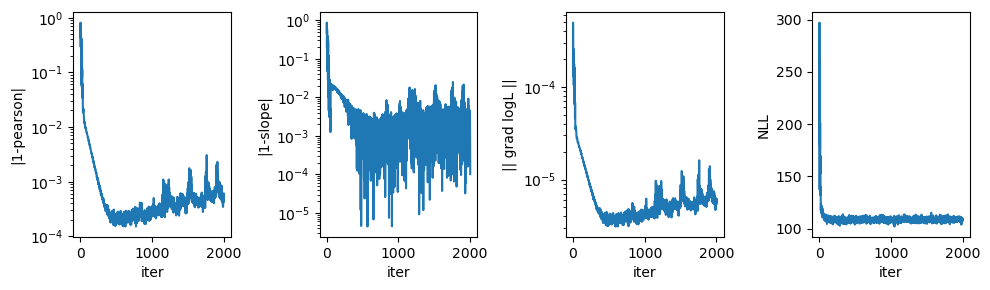

In [391]:
callbacks[0].plot();

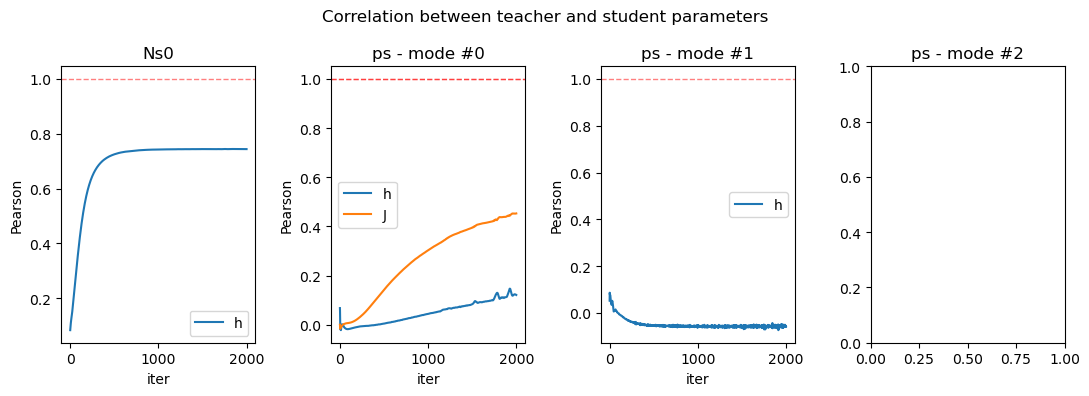

In [392]:
callbacks[1].plot(figsize=(11, 4));

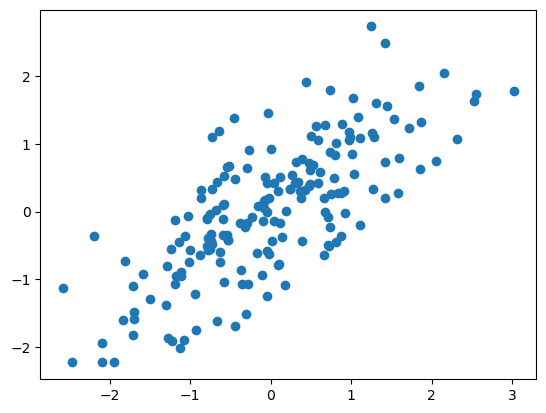

In [393]:
plt.scatter(model.round_zero.h.detach().numpy(), k_teacher)

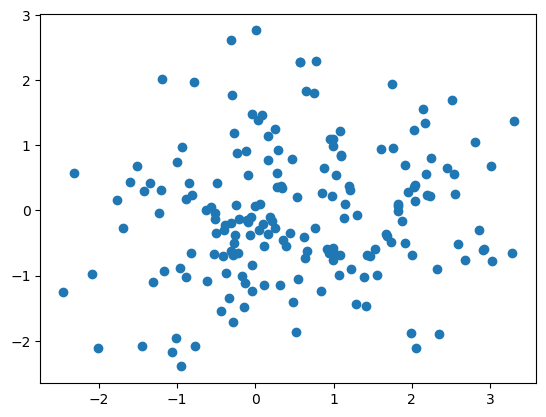

In [394]:
plt.scatter(model.selection.modes[0].h.detach().numpy(), h_teacher)

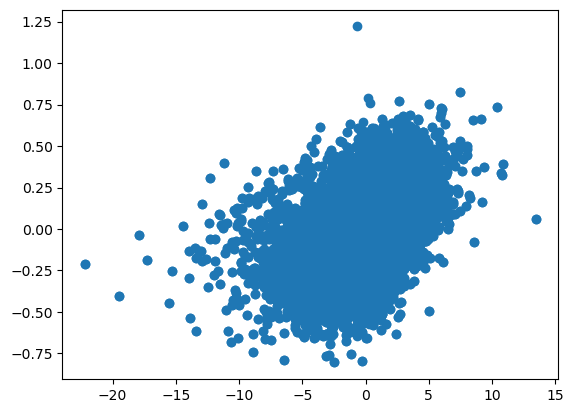

In [395]:
plt.scatter(model.selection.modes[0].J.detach().numpy(), J_teacher)

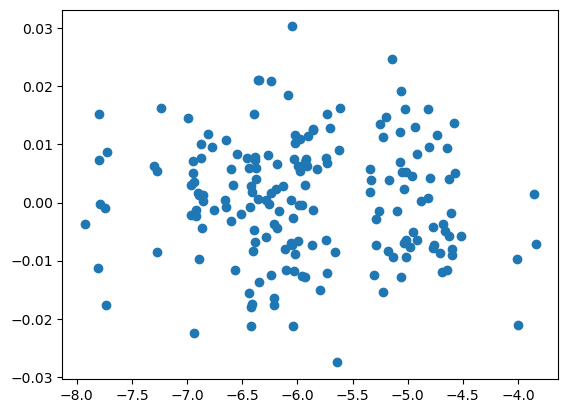

In [396]:
plt.scatter(model.selection.modes[1].h.detach().numpy(), h_beads_teacher)